In [1]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pandas import isnull
from numpy import count_nonzero
from pyspark.sql.functions import col, count, isnan, when, coalesce, lag, lead, sum
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

concatenated_dataset = pd.read_csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/concatenated_dataset.csv")

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
external_dataset = spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/external factors dataset/Precipitation_Avg-temperature.csv", header=True, inferSchema=True)

In [5]:
# Check unique values of cities
unique_cities = external_dataset.select("Name").distinct()
unique_cities.show()

+----------------+
|            Name|
+----------------+
|  KURUNEGALA, CE|
|    PUTTALAM, CE|
|     COLOMBO, CE|
|NUWARA ELIYA, CE|
|   CHINA BAY, CE|
+----------------+



In [6]:

# Filter the dataset to include only specific cities
cities_to_keep = ['KURUNEGALA, CE', 'COLOMBO, CE', 'NUWARA ELIYA, CE']

# Use DataFrame.filter() method to filter the dataset
filtered_df = external_dataset.filter(external_dataset['Name'].isin(cities_to_keep))

# Display the filtered dataset
filtered_df.show()


+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|  90|  65|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|  88|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|  89|  68|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|  90|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83|  89|  71|
|CEM00043441|KURUNEGA

In [7]:
# Check unique values of cities
unique_cities = filtered_df.select("Name").distinct()
unique_cities.show()

+----------------+
|            Name|
+----------------+
|  KURUNEGALA, CE|
|     COLOMBO, CE|
|NUWARA ELIYA, CE|
+----------------+



In [8]:
# Define the replacements you want to make
name_replacements = {
    "KURUNEGALA, CE": "Kurunegala Proper",
    "COLOMBO, CE": "Colombo Proper",
    "NUWARA ELIYA, CE": "Nuwara Eliya Proper"
}

# Create a DataFrame with the desired replacements
df_updated = filtered_df.withColumn(
    "Name",
    when(col("Name") == "KURUNEGALA, CE", "Kurunegala Proper")
    .when(col("Name") == "COLOMBO, CE", "Colombo Proper")
    .when(col("Name") == "NUWARA ELIYA, CE", "Nuwara Eliya Proper")
    .otherwise(col("Name"))  # Keep the original value if none of the conditions match
)

# Show the updated DataFrame
df_updated.show()


+-----------+-----------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|             Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+-----------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|NULL|  72|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|  88|  69|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|  90|  65|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|  88|  71|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|  89|  68|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|  90|  71|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83

In [9]:
# Check unique values of cities
unique_cities = df_updated.select("Name").distinct()
unique_cities.show()

+-------------------+
|               Name|
+-------------------+
|  Kurunegala Proper|
|     Colombo Proper|
|Nuwara Eliya Proper|
+-------------------+



In [10]:
# Check for null values in the DataFrame
df_updated.select([count(when(col(c).isNull(), c)).alias(c) for c in df_updated.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|Name|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|  17|   0| 583| 926|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [11]:
# Initialize a counter for null values
null_count = df_updated.filter(col("TMAX").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMAX", 1).over(backward_windowSpec)
    df_updated = df_updated.withColumn("TMAX", coalesce("TMAX", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMAX", 1).over(forward_windowSpec)
    df_updated = df_updated.withColumn("TMAX", coalesce("TMAX", next_value))
    
    # Update the null count
    null_count = df_updated.filter(col("TMAX").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [12]:
# Initialize a counter for null values
null_count = df_updated.filter(col("TMIN").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMIN", 1).over(backward_windowSpec)
    df_updated = df_updated.withColumn("TMIN", coalesce("TMIN", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMIN", 1).over(forward_windowSpec)
    df_updated = df_updated.withColumn("TMIN", coalesce("TMIN", next_value))
    
    # Update the null count
    null_count = df_updated.filter(col("TMIN").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [13]:
df_updated.show()

+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|               Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-01| 0.0|  81|  89|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-01| 0.0|  61|  71|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|  71|  72|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-02| 0.0|  78|  71|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-02| 0.0|  59|  87|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-03| 0.0|  81|  90|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.

In [14]:
# Check for null values in the DataFrame
df_updated.select([count(when(col(c).isNull(), c)).alias(c) for c in df_updated.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|Name|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|  17|   0|   0|   0|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [15]:
# Count the number of rows in the DataFrame
data_count = df_updated.count()

# Show the length of the DataFrame
print("Length of DataFrame:", data_count)

Length of DataFrame: 5230


In [16]:
# Drop duplicates from the DataFrame
data_no_duplicates = df_updated.dropDuplicates()

# Show the first few rows of the DataFrame after dropping duplicates
data_no_duplicates.show()

+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|               Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-01| 0.0|  81|  89|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-01| 0.0|  61|  71|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|  71|  72|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-02| 0.0|  78|  71|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-02| 0.0|  59|  87|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-03| 0.0|  81|  90|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.

In [17]:
# Count the number of rows in the DataFrame
data_count = df_updated.count()

# Show the length of the DataFrame
print("Length of DataFrame:", data_count)

Length of DataFrame: 5230


In [18]:
external_data = data_no_duplicates.toPandas()

In [19]:
external_data

,STATION,Name,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,CEM00043466,Colombo Proper,6.900,79.867,7.0,2019-01-01,0.00,81,89,74
1,CE000434730,Nuwara Eliya Proper,6.967,80.767,1880.0,2019-01-01,0.00,61,71,49
2,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2019-01-02,0.00,78,71,72
3,CEM00043466,Colombo Proper,6.900,79.867,7.0,2019-01-02,0.00,78,71,74
4,CE000434730,Nuwara Eliya Proper,6.967,80.767,1880.0,2019-01-02,0.00,59,87,49
...,...,...,...,...,...,...,...,...,...,...
5225,CE000434730,Nuwara Eliya Proper,6.967,80.767,1880.0,2023-07-18,0.02,60,66,58
5226,CEM00043466,Colombo Proper,6.900,79.867,7.0,2023-07-23,0.00,84,89,57
5227,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2023-09-26,0.10,79,87,59
5228,CEM00043466,Colombo Proper,6.900,79.867,7.0,2023-12-22,NaN,83,93,75


In [20]:
import pandas as pd

#Save preprocessed dataset
external_data.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/external factors dataset/preprocessed_external_dataset.csv', index=False)

In [21]:
# Load the dataset
external= spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/external factors dataset/preprocessed_external_dataset.csv", header=True, inferSchema=True)

hcho = spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/concatenated_dataset.csv", header=True, inferSchema=True)


In [22]:
external.show()

+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|               Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-01| 0.0|  81|  89|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-01| 0.0|  61|  71|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|  71|  72|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-02| 0.0|  78|  71|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-02| 0.0|  59|  87|  49|
|CEM00043441|  Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-03| 0.0|  81|  90|  74|
|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.

In [23]:
hcho.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|   2.625522171968E-4|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|   2.625522171968E-4|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|   2.625522171968E-4|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|   2.362357772653E-4|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|   1.908293886956E-4|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|   2.099320518114E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|   1.785337298892E-4|     Colombo Proper|  2019-01-05|2019-01

In [24]:
hcho = hcho.withColumnRenamed("HCHO Reading", "HCHO_Reading")

hcho = hcho.withColumnRenamed("Current Date", "Current_Date")

hcho = hcho.withColumnRenamed("Next Date", "Next_Date")

In [25]:
hcho.show()

+--------------------+-------------------+------------+----------+
|        HCHO_Reading|           Location|Current_Date| Next_Date|
+--------------------+-------------------+------------+----------+
|   2.625522171968E-4|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|   2.625522171968E-4|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|   2.625522171968E-4|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|   2.362357772653E-4|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|   1.908293886956E-4|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|   2.099320518114E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|   1.785337298892E-4|     Colombo Proper|  2019-01-05|2019-01

In [26]:
join_df = hcho.join(external, (hcho.Location == external.Name) & (hcho.Current_Date == external.DATE), "inner" )
join_df.show()

+--------------------+-------------------+------------+----------+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|        HCHO_Reading|           Location|Current_Date| Next_Date|    STATION|               Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+--------------------+-------------------+------------+----------+-----------+-------------------+--------+---------+---------+----------+----+----+----+----+
|   2.625522171968E-4|Nuwara Eliya Proper|  2019-01-01|2019-01-02|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-01| 0.0|  61|  71|  49|
|   2.625522171968E-4|     Colombo Proper|  2019-01-02|2019-01-03|CEM00043466|     Colombo Proper|     6.9|   79.867|      7.0|2019-01-02| 0.0|  78|  71|  74|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|CE000434730|Nuwara Eliya Proper|   6.967|   80.767|   1880.0|2019-01-02| 0.0|  59|  87|  49|
|9.852118897938794E-5|     Colombo Proper|  20

In [27]:
join_df.count()

5229

In [28]:
join_df = join_df.drop("Name", "DATE")

In [29]:
join_df.show()

+--------------------+-------------------+------------+----------+-----------+--------+---------+---------+----+----+----+----+
|        HCHO_Reading|           Location|Current_Date| Next_Date|    STATION|LATITUDE|LONGITUDE|ELEVATION|PRCP|TAVG|TMAX|TMIN|
+--------------------+-------------------+------------+----------+-----------+--------+---------+---------+----+----+----+----+
|   2.625522171968E-4|Nuwara Eliya Proper|  2019-01-01|2019-01-02|CE000434730|   6.967|   80.767|   1880.0| 0.0|  61|  71|  49|
|   2.625522171968E-4|     Colombo Proper|  2019-01-02|2019-01-03|CEM00043466|     6.9|   79.867|      7.0| 0.0|  78|  71|  74|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|CE000434730|   6.967|   80.767|   1880.0| 0.0|  59|  87|  49|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|CEM00043466|     6.9|   79.867|      7.0| 0.0|  81|  90|  74|
|   1.908293886956E-4|Nuwara Eliya Proper|  2019-01-03|2019-01-04|CE000434730|   6.967|   80.767|   1880

In [31]:
final_data = join_df.toPandas()

In [32]:
final_data

,HCHO_Reading,Location,Current_Date,Next_Date,STATION,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
0,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02,CE000434730,6.967,80.767,1880.0,0.00,61,71,49
1,0.000263,Colombo Proper,2019-01-02,2019-01-03,CEM00043466,6.900,79.867,7.0,0.00,78,71,74
2,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03,CE000434730,6.967,80.767,1880.0,0.00,59,87,49
3,0.000099,Colombo Proper,2019-01-03,2019-01-04,CEM00043466,6.900,79.867,7.0,0.00,81,90,74
4,0.000191,Nuwara Eliya Proper,2019-01-03,2019-01-04,CE000434730,6.967,80.767,1880.0,0.00,59,71,49
...,...,...,...,...,...,...,...,...,...,...,...,...
5224,0.000075,Kurunegala Proper,2023-12-27,2023-12-28,CEM00043441,7.467,80.367,116.0,0.47,81,88,76
5225,0.000051,Kurunegala Proper,2023-12-28,2023-12-29,CEM00043441,7.467,80.367,116.0,0.29,79,83,76
5226,0.000127,Kurunegala Proper,2023-12-29,2023-12-30,CEM00043441,7.467,80.367,116.0,0.38,77,82,75
5227,0.000158,Kurunegala Proper,2023-12-30,2023-12-31,CEM00043441,7.467,80.367,116.0,0.47,80,87,74


In [33]:
import pandas as pd

#Save preprocessed dataset
final_data.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/external factors dataset/final.csv', index=False)

In [34]:
data = pd.read_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/external factors dataset/final.csv')

In [35]:
data

,HCHO_Reading,Location,Current_Date,Next_Date,STATION,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
0,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02,CE000434730,6.967,80.767,1880.0,0.00,61,71,49
1,0.000263,Colombo Proper,2019-01-02,2019-01-03,CEM00043466,6.900,79.867,7.0,0.00,78,71,74
2,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03,CE000434730,6.967,80.767,1880.0,0.00,59,87,49
3,0.000099,Colombo Proper,2019-01-03,2019-01-04,CEM00043466,6.900,79.867,7.0,0.00,81,90,74
4,0.000191,Nuwara Eliya Proper,2019-01-03,2019-01-04,CE000434730,6.967,80.767,1880.0,0.00,59,71,49
...,...,...,...,...,...,...,...,...,...,...,...,...
5224,0.000075,Kurunegala Proper,2023-12-27,2023-12-28,CEM00043441,7.467,80.367,116.0,0.47,81,88,76
5225,0.000051,Kurunegala Proper,2023-12-28,2023-12-29,CEM00043441,7.467,80.367,116.0,0.29,79,83,76
5226,0.000127,Kurunegala Proper,2023-12-29,2023-12-30,CEM00043441,7.467,80.367,116.0,0.38,77,82,75
5227,0.000158,Kurunegala Proper,2023-12-30,2023-12-31,CEM00043441,7.467,80.367,116.0,0.47,80,87,74


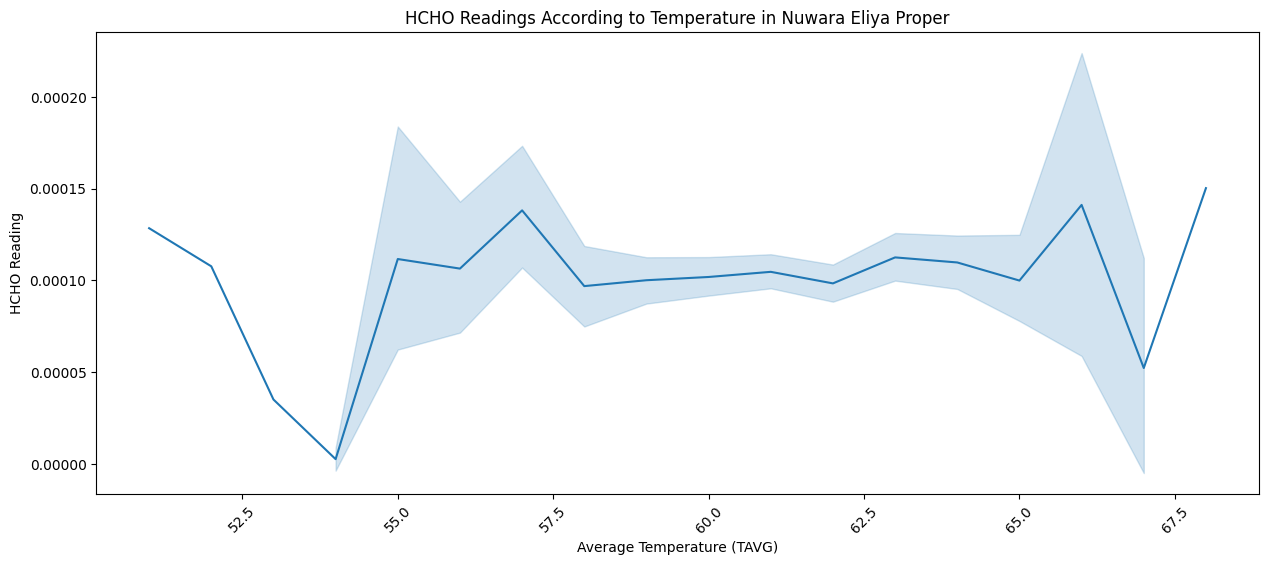

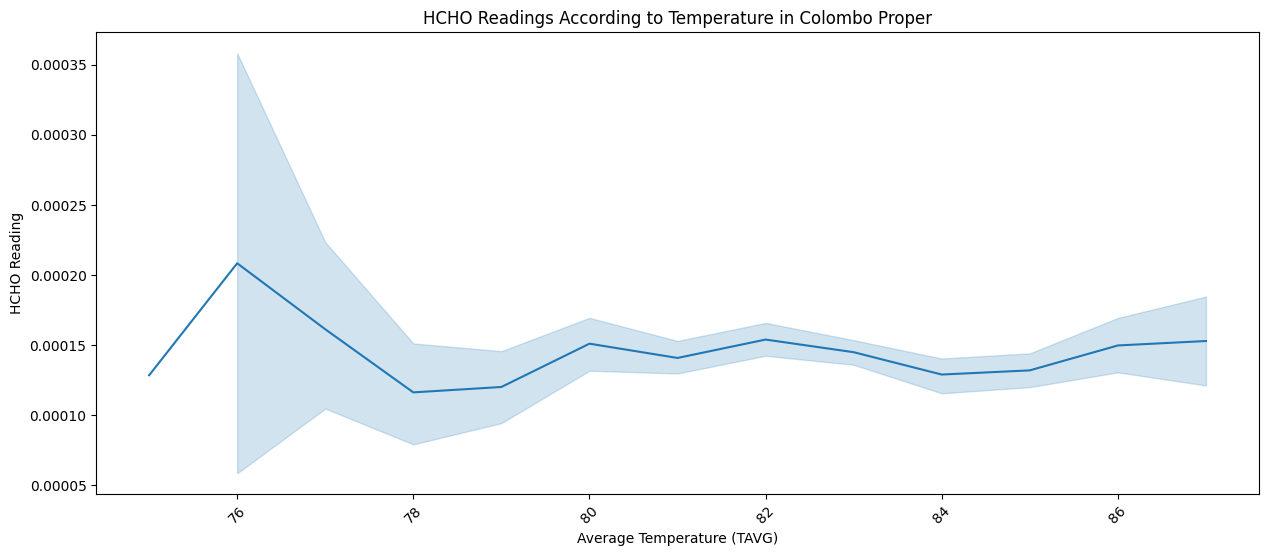

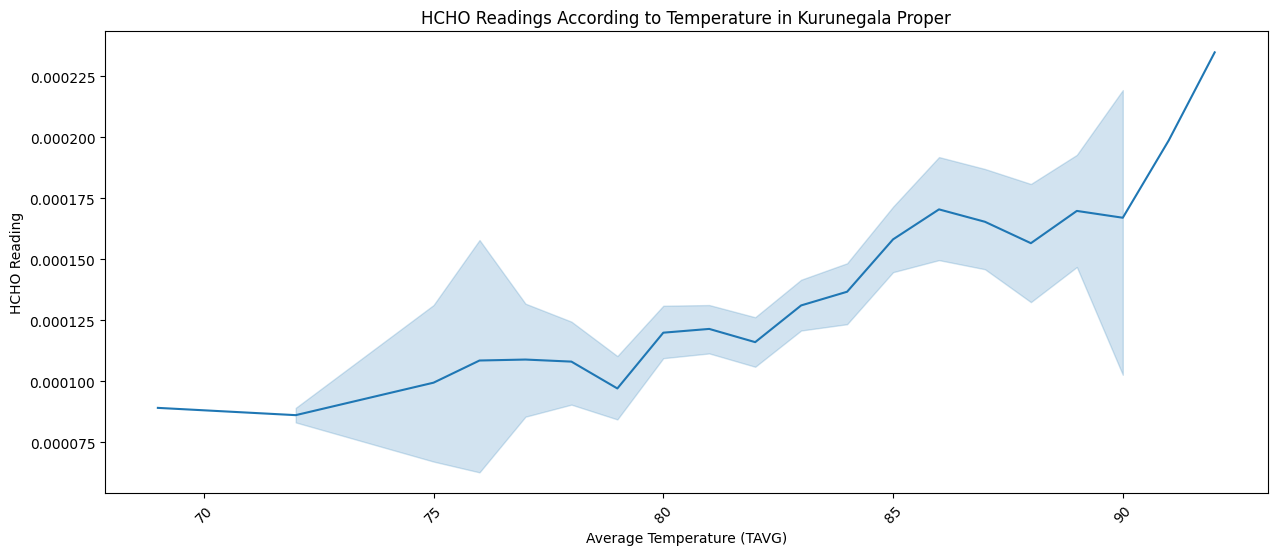

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each unique city in the data
for city in data['Location'].unique():
    # Filter the data for the current city
    city_data = data[data['Location'] == city]
    
    # Plotting the trend of HCHO readings according to temperature for the current city
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='TAVG', y='HCHO_Reading', data=city_data)
    
    # Add title, labels, and rotation to x-axis ticks
    plt.title(f'HCHO Readings According to Temperature in {city}')
    plt.xlabel('Average Temperature (TAVG)')
    plt.ylabel('HCHO Reading')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()


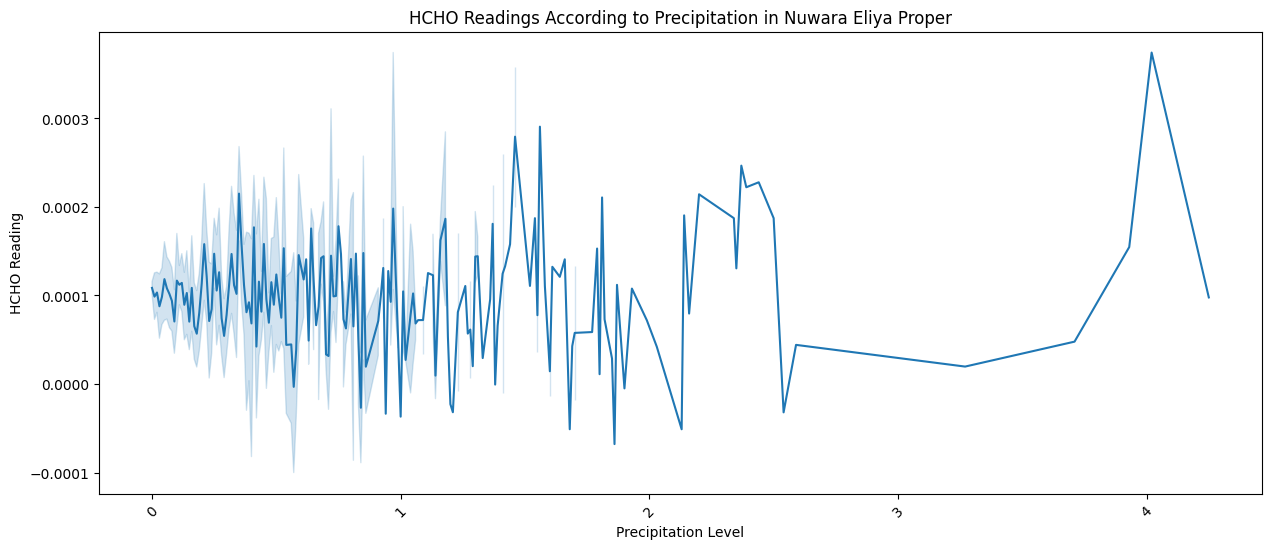

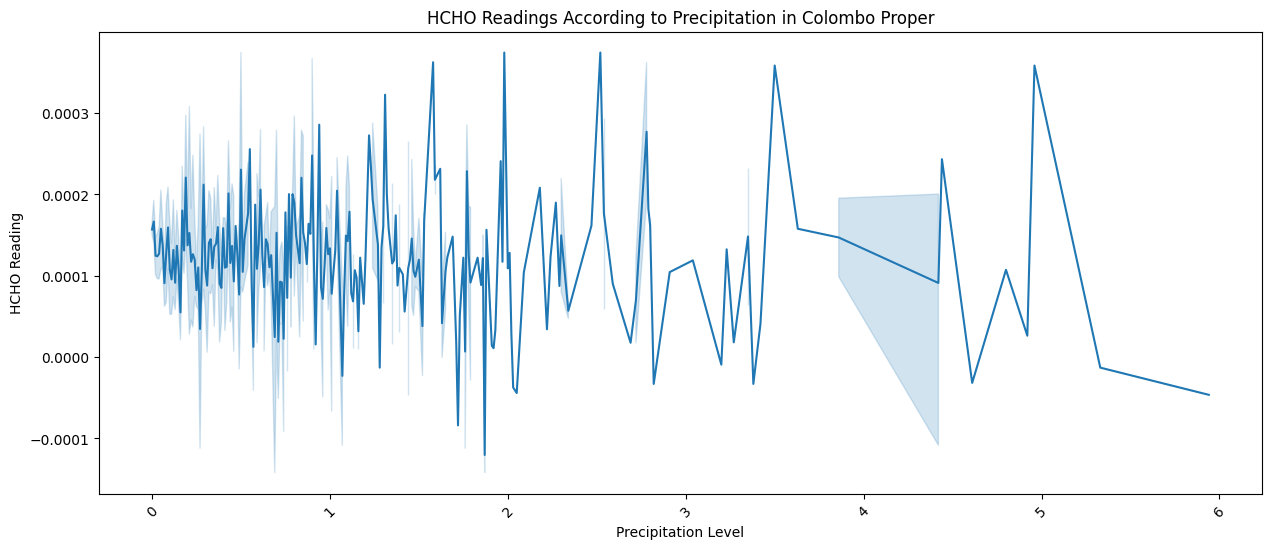

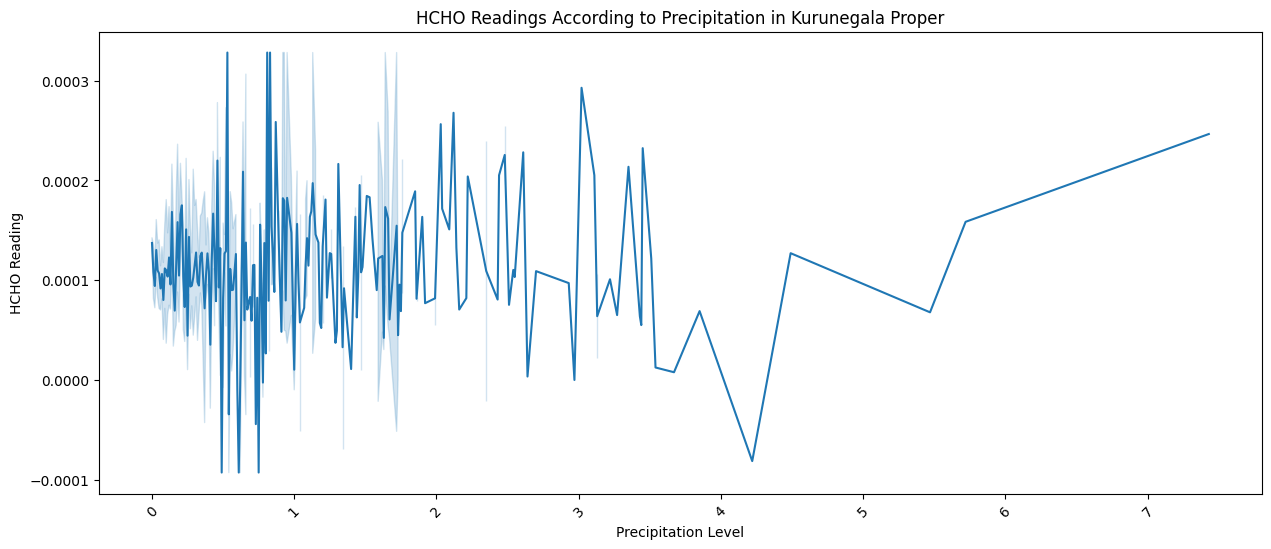

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each unique city in the data
for city in data['Location'].unique():
    # Filter the data for the current city
    city_data = data[data['Location'] == city]
    
    # Plotting the trend of HCHO readings according to temperature for the current city
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='PRCP', y='HCHO_Reading', data=city_data)
    
    # Add title, labels, and rotation to x-axis ticks
    plt.title(f'HCHO Readings According to Precipitation in {city}')
    plt.xlabel('Precipitation Level')
    plt.ylabel('HCHO Reading')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()
